In [54]:
%matplotlib inline
from scipy.stats import norm
from nilearn import plotting
import pandas as pd
import sys
import os
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import make_second_level_design_matrix, SecondLevelModel
from nilearn.datasets import load_mni152_brain_mask

import matplotlib.pyplot as plt
import nibabel as nib


In [55]:
contrasts = [['condition-maps', 'memory',[]],
             ['contrast-maps','highTrust_memory_vs_lowTrust_memory',[]],
             ['contrast-maps','lowTrust_memory_vs_self_memory',[]],
             ['contrast-maps','highTrust_memory_vs_self_memory',[]],
             ['contrast-maps','highTrust_perspective_vs_lowTrust_perspective',[]],
             ['contrast-maps','lowTrust_perspective_vs_self_perspective',[]],
             ['contrast-maps','highTrust_perspective_vs_self_perspective',[]],
             ['contrast-maps','highlowTrust_perspective_vs_self_perspective',[]]]
contrasts = [ ['contrast-maps','self_v_other',[]]]

In [56]:
first_level_dir =  '/oak/stanford/groups/jzaki/scp_2022/bids/derivatives/study_1_2_compiled/contrast_self-v-other/contrast_files_study2/'
#first_level_dir = '/oak/stanford/groups/jzaki/Social_Networks/master/bids/derivatives/first-level-ian/'

contrast_name = 'self_v_other'#'other_v_self'
save_file_prefix = 'contrast-maps' 
task_label = 'stressbuffer'
out_dir =  '/oak/stanford/groups/jzaki/scp_2022/bids/derivatives/study_1_2_compiled/contrast_self-v-other/second_level/study2/'
bad_subs = []


In [57]:
def compute_second_level(first_level_dir,contrast_name,save_file_prefix,task_label,out_dir, bad_subs):
    contrast_file = '_contrast-' + contrast_name + '_smoothing-8mm_z-map_rp.nii.gz'

    zmap_out_dir = os.path.join(out_dir,  contrast_name)
    stat_out_dir = os.path.join(out_dir,  contrast_name,'plotting')


            
    second_level_input = [nib.load(os.path.join(first_level_dir,file)) for file in os.listdir(first_level_dir) if file.split('_')[0] not in bad_subs]
    subjs = [file.split('_')[0] for file in second_level_input for file in os.listdir(first_level_dir) if file.split('_')[0] not in bad_subs]
 

    #second_level_input = [file for file in second_level_input if os.path.isfile(os.path.join(first_level_dir,
   #                                                                                          file))]
    n_subj = len(second_level_input)
    print('we have ' + str(len(second_level_input)) + ' subjects')
    #print(second_level_input)
    
    if n_subj > 30:
        if not os.path.exists(stat_out_dir):
            os.makedirs(stat_out_dir)
        if not os.path.exists(zmap_out_dir):
            os.makedirs(zmap_out_dir)
    
    
        ## Calculate second level model
        design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])
        second_level_model = SecondLevelModel()
        second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)
        z_map = second_level_model.compute_contrast(output_type='z_score')

        ## Threshold
        alpha_level = 0.05
        mask_img = load_mni152_brain_mask()
        z_thresholded, threshold = threshold_stats_img(stat_img=z_map, 
                                       mask_img=mask_img, alpha=alpha_level, 
                                       height_control='fdr', cluster_threshold = 10, two_sided=True)
    
        # Plot uncorrected
        display_uncorrected = plotting.plot_stat_map(z_map, 
                       title = contrast_name +', not corrected, threshold = 2 ',
                                threshold = 2, display_mode = 'mosaic')
        display_uncorrected.savefig(os.path.join(stat_out_dir, 'uncorrected_threshold-2_smoothing-8mm_n-'+str(n_subj) + '_plot-stat-map_rp.png'))

        # Plot corrected
        display_corrected = plotting.plot_stat_map(z_thresholded, 
                       title = contrast_name +', alpha level ' + str(alpha_level) + ' (fdr corrected), threshold = ' + str(round(threshold,2)),
                                threshold = threshold, display_mode = 'mosaic')
        display_corrected.savefig(os.path.join(stat_out_dir, 'corrected_threshold-'+str(round(threshold,2))+'_smoothing-8mm_n-'+str(n_subj) + '_plot-stat-map_rp.png'))
        print("Z map for second level model plotted to " + os.path.join(stat_out_dir, 'corrected_threshold-'+str(round(threshold,2))+'_smoothing-8mm_plot-stat-map_rp.png'))


        # Save Z maps
        nib.save(z_map, os.path.join(zmap_out_dir,'contrast-' + contrast_name + '_smoothing-8mm_n-'+str(n_subj) + '_z-map_rp.nii.gz'))

        print("Z map for second level model saved to " + 
                  os.path.join(zmap_out_dir, 'contrast-' + contrast_name + '_smoothing-8mm_n-'+str(n_subj) + '_z-map_rp.nii.gz'))
        
    else:
        print("We have too few participants to make a group-level inference.")






['contrast-maps', 'self_v_other', []]
we have 46 subjects
Z map for second level model plotted to /oak/stanford/groups/jzaki/scp_2022/bids/derivatives/study_1_2_compiled/contrast_self-v-other/second_level/study2/self_v_other/plotting/corrected_threshold-2.34_smoothing-8mm_plot-stat-map_rp.png
Z map for second level model saved to /oak/stanford/groups/jzaki/scp_2022/bids/derivatives/study_1_2_compiled/contrast_self-v-other/second_level/study2/self_v_other/contrast-self_v_other_smoothing-8mm_n-46_z-map_rp.nii.gz


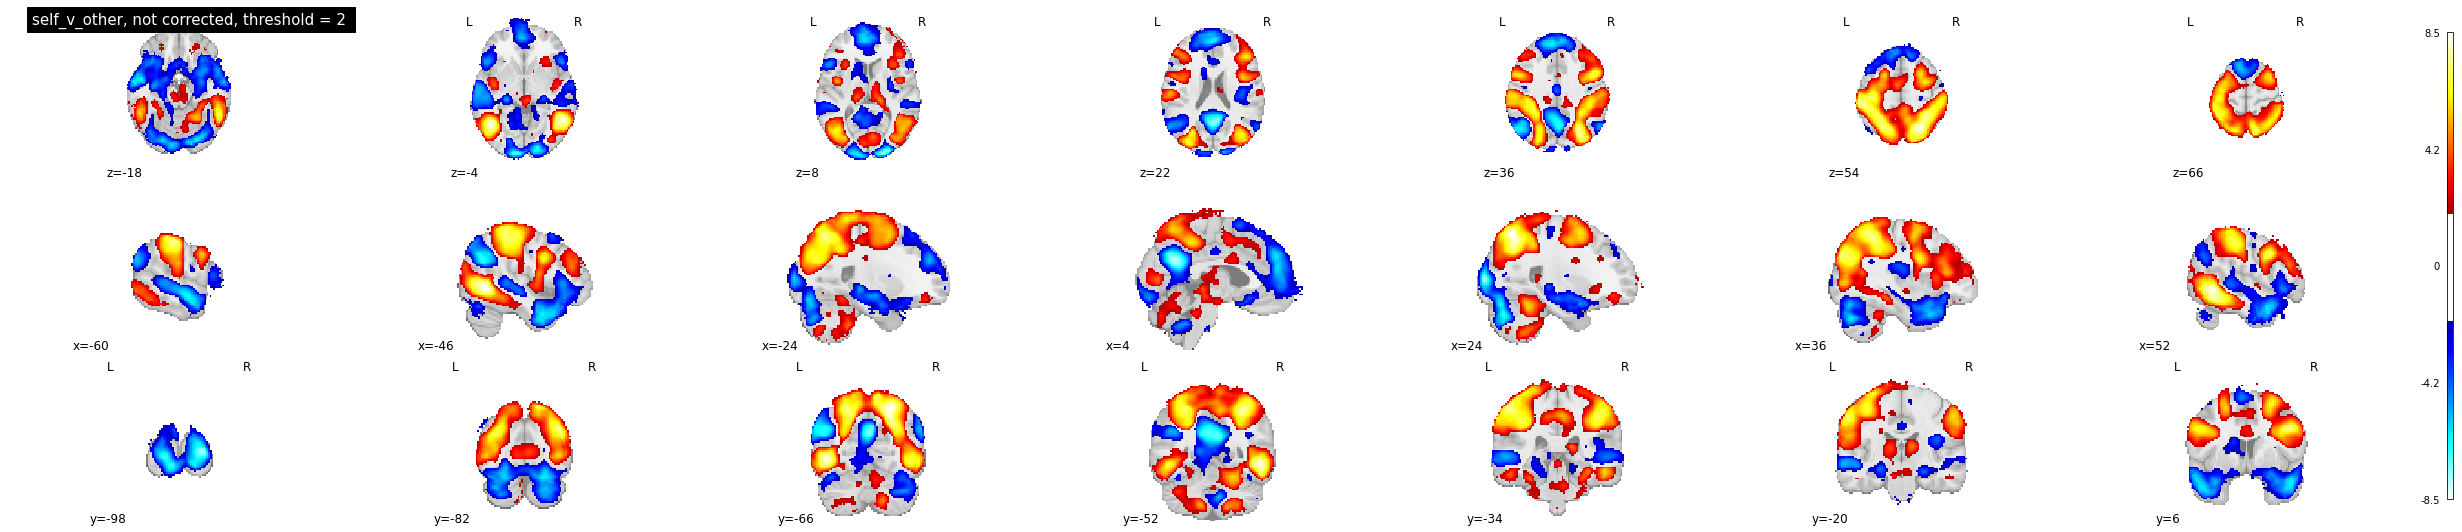

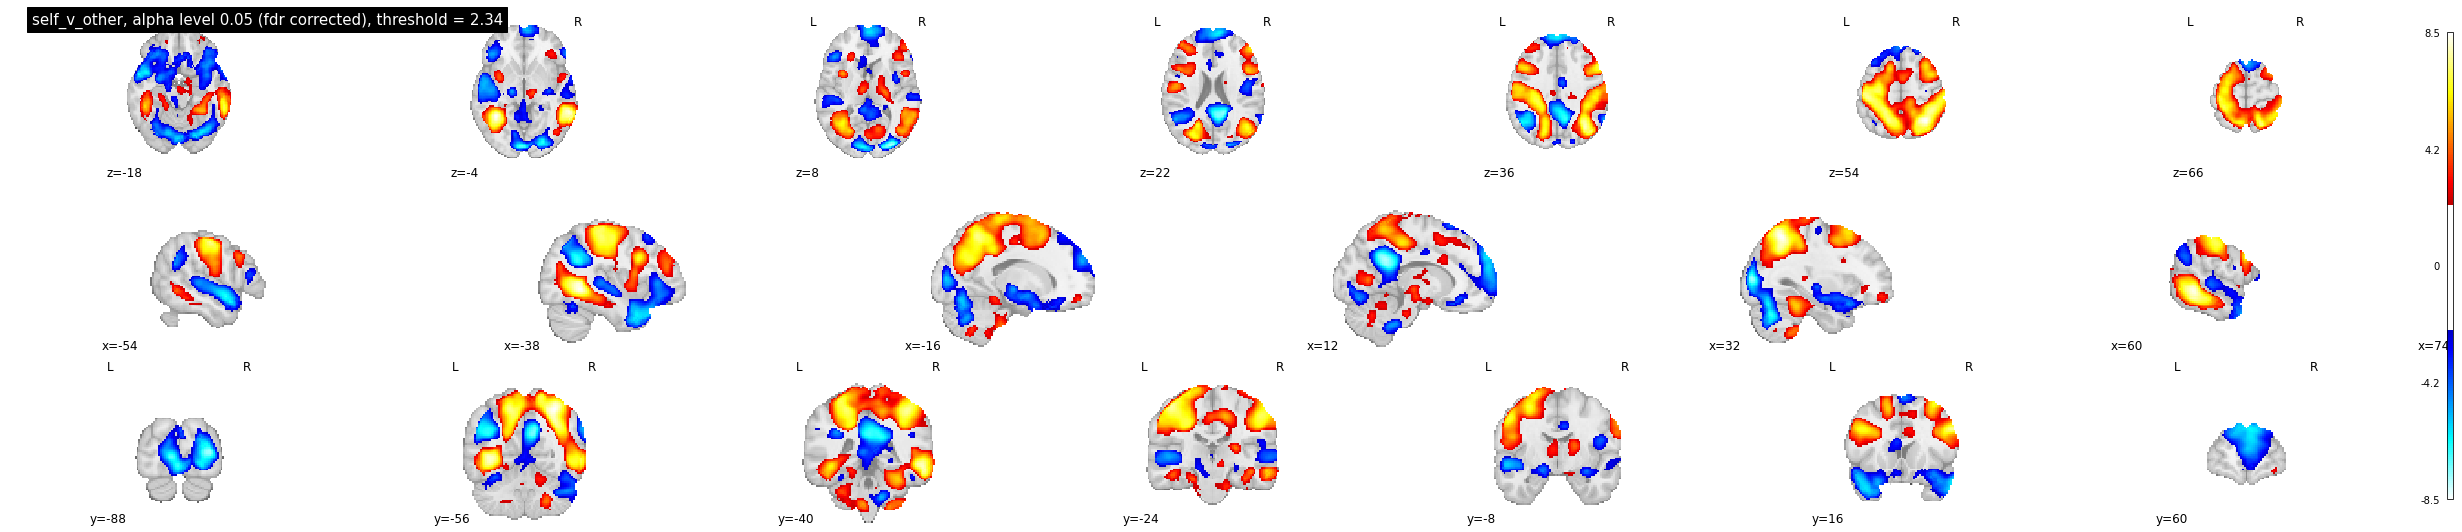

In [58]:
for contrast_idx in range(len(contrasts)):
    print(contrasts[contrast_idx])
    compute_second_level(first_level_dir=first_level_dir,
                    contrast_name = contrasts[contrast_idx][1],
                    save_file_prefix = contrasts[contrast_idx][0],
                    task_label = task_label,
                    out_dir = out_dir,
                    bad_subs = contrasts[contrast_idx][2])

In [ ]:
#compute_second_level(first_level_dir=first_level_dir,
#                    contrast_name = contrasts[3][1],
#                    save_file_prefix = contrasts[3][0],
#                    task_label = task_label,
#                    out_dir = out_dir)

In [9]:
first_level_dir = '/oak/stanford/groups/jzaki/Social_Networks/master/bids/derivatives/first-level-rp/sub-01006/task-stressbuffer/first-level-model/contrast-maps/sub-01006_contrast-highlowTrust_perspective_vs_self_perspective_smoothing-8mm_z-map_rp.nii.gz

SyntaxError: EOL while scanning string literal (<ipython-input-9-a3873be59cc5>, line 1)